# Νευρωνικά Δίκτυα και Ευφυή Υπολογιστικά Συστήματα, ΣΗΜΜΥ ΕΜΠ, 2022-2023
Ομάδα 42
- Βαγγελάτος Οδυσσεύς (03118177)
- Γαλανόπουλος Νικόλαος (03118024)
- Νικολόπουλος Χρήστος (03118188)


In [14]:
!pip install pip
!pip install scikit-learn
!pip install imbalanced-learn
!pip install numpy
!pip install matplotlib
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from tabulate import tabulate

from sklearn.metrics import make_scorer, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA

import time

# [🔗](http://archive.ics.uci.edu/ml/datasets/Ionosphere) Μέρος 1. UCI Dataset - Ionosphere

## Εισαγωγή και επισκόπηση

Το dataset προέρχεται από πείραμα στο Goose Bay του Labrador, όπου με ένα σύνολο κεραιών εκπέμπεται ακτινοβολία προς την ιονόσφαιρα και αναλύεται η ανακλώμενη ακτινοβολία που γυρίζει πίσω. Στόχος είναι η ταξινόμησή της σε χρήσιμη (g), εφόσον περιέχει πληροφορία για τη δομή της ιονόσφαιρας (όταν έγινε ανάκλαση με ελέυθερο ηλεκτρόνιό της), και άχρηστη (b), στην περίπτωση που πέρασε το μεγαλύτερο μέρος μέσα από το ατμοσφαιρικό στρώμα. Κάθε γραμμή εισόδου περιέχει 34 αριθμούς: το πραγματικό και φανταστικό μέρος της αυτοσυσχέτισης καθενός από τους 17 παλμούς που ελήφθησαν.

In [16]:
URL_DATASET = "http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
df = pd.read_csv(URL_DATASET, header = None)
X, y = df.iloc[:, 0:34], df[34]

Δε χρειάστηκε μετασχηματισμός του αρχείου CSV εισόδου.

In [17]:
print(f"Πλήθος δειγμάτων: {X.shape[0]}")
print(f"Πλήθος χαρακτηριστικών: {X.shape[1]}")
print(f"Είδος χαρακτηριστικών: {X.dtypes.unique()}")

Πλήθος δειγμάτων: 351
Πλήθος χαρακτηριστικών: 34
Είδος χαρακτηριστικών: [dtype('int64') dtype('float64')]



Οι αρχικές μετρήσεις από τις οποίες προκύπτει το dataset είναι μιγαδικοί αριθμοί, οι οποίοι δεν έχουν διάταξη. Ωστόσο, οι τιμές κάθε κολόνας είναι μόνο το φανταστικό ή μόνο το πραγματικό μέρος, επομένως ορίζεται διάταξη μεταξύ των τιμών αυτών.

In [18]:
X = X.astype("float64") 
## Αφού όλοι οι αριθμοί αποτελούν το πραγματικό ή φανταστικό μέρος αυτοσυσχέτισης
## επιλέγουμε να έχουμε ομοιόμορφους τύπους δεδομένων, δηλαδή float64
print(f"Είδος χαρακτηριστικών: {X.dtypes.unique()}")

Είδος χαρακτηριστικών: [dtype('float64')]


Δεν υπάρχουν επικεφαλίδες, ούτε αρίθμηση γραμμών.

Η ετικέτα των κλάσεων ισόυται με `g` (good, χρήσιμη ακτινοβολία) ή `b` (bad, άχρηστη πληροφορία) και βρίσκεται στην τελευταία στήλη.

Δεν υπάρχουν απουσιάζουσες τιμές:


In [19]:
print(f"Απουσιάζουσες τιμές: {df.isnull().values.sum()}")

Απουσιάζουσες τιμές: 0


In [20]:
print(f"Πλήθος Κλάσεων: 2")
freqs = (100 * y.value_counts() / y.size).map("{:.2f}%".format)
print(f"Συχνότητα Δειγμάτων Κλάσεων:\n{freqs}")

Πλήθος Κλάσεων: 2
Συχνότητα Δειγμάτων Κλάσεων:
g    64.10%
b    35.90%
Name: 34, dtype: object


Εφόσον η κλάση `g` εμφανίζεται σε παραπάνω από 60% των γραμμών εισόδου, το dataset δεν είναι ισορροπημένο.

## Προετοιμασία

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42) # Fixed random_state for reproducibility.

In [22]:
print(f"Split percentage: {len(y_test) / len(y) * 100 : .3f}%")

Split percentage:  30.199%


## Ταξινόμηση

In [ ]:
clfs = [DummyClassifier(), GaussianNB(), 
        KNeighborsClassifier(), LogisticRegression()]

In [ ]:
accs, f1s = [], []  # accuracy(s), F1-score(s)

for clf in clfs:
  preds = clf.fit(X_train, y_train).predict(X_test) 
  accs.append(100 * accuracy_score(y_test, preds))
  f1s.append(100 * f1_score(y_test, preds, pos_label = 'g'))

print(tabulate({"Classifier": [str(c)[:-2] for c in clfs], "Accuracy (%)": accs, "F1-score (%)": f1s}, headers="keys", floatfmt=".3f"))

Classifier              Accuracy (%)    F1-score (%)
--------------------  --------------  --------------
DummyClassifier               63.208          77.457
GaussianNB                    89.623          92.199
KNeighborsClassifier          85.849          89.933
LogisticRegression            87.736          91.034


| **Metric**  | **Dummy** | **Gaussian NB** | **5-NN** | **Logistic  Regression** |
|:-----------:|:---------:|:---------------:|:--------:|:------------:|
| Accuracy (%)| 63.208    | 89.623          | 85.849   | 87.736       |
| F1-Score (%)| 77.457    | 92.199          | 89.933   | 91.034       |

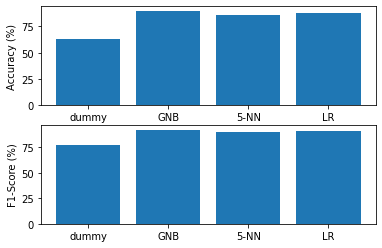

In [ ]:
names = ['dummy', 'GNB', '5-NN', 'LR'] # By default sklearn uses k = 5 for NN
fig, ax = plt.subplots(nrows = 2)
ax[0].set_ylabel("Accuracy (%)")
ax[1].set_ylabel("F1-Score (%)")
ax[0].bar(names, accs)
ax[1].bar(names, f1s)
plt.show()

Ο ταξινομητής με το καλύτερο accuracy ταυτίζεται με εκείνον με το καλύτερο F1-score και είναι ο GaussianNB. Παρατηρούμε ότι ο dummy classifier έχει τη χειρότερη επίδοση, σύμφωνα και με τις δύο μετρικές.



## Βελτιστοποίηση

In [ ]:
selector = VarianceThreshold()
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA()
f1_scorer = make_scorer(f1_score, pos_label = 'g') # Δεν γίνεται να γράψουμε scoring = 'f1' απ'ευθείας στο GridSearchCV 
# διότι τότε υποθέτει pos_label = '1', ενώ τα labels μας είναι στο {'b','g'}

#### Dummy Classifier Optimization

In [ ]:
clf = DummyClassifier()

Οι "στρατηγικές" του dummy classifier, χρησιμοποιούν μόνο τα labels και όχι τα χαρακτηριστικά των δειγμάτων. Συνεπώς, δεν πρόκειται να "δούμε" βελτίωση με εισαγωγή variance threshold, PCA ή scaler. Το μόνο στοιχείο του τυπικού pipeline που μπορεί να αλλάξει την απόδοση του dummy classifier είναι ο sampler και συγκεκριμένα για τις στρατηγικές που υπολογίζουν à priori πιθανότητες με βάση τα train δεδομένα.

#####Accuracy

######Χωρίς Sampler

In [ ]:
pipe = Pipeline(steps=[('dmm', clf)], memory = 'tmp')

In [ ]:
strategies = ['most_frequent', 'prior', 'stratified', 'uniform']

estimator = GridSearchCV(pipe, dict(dmm__strategy = strategies), 
                         cv = 10, scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'dmm__strategy': 'most_frequent'}
Best Score: 64.500%


In [ ]:
constants = ['b', 'g']

estimator = GridSearchCV(pipe, dict(dmm__strategy = ['constant'], dmm__constant = constants), 
                         cv = 10, scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'dmm__constant': 'g', 'dmm__strategy': 'constant'}
Best Score: 64.500%


In [ ]:
# Our choice for 'maximizing accuracy'
print(f"Dummy: Best Parameters: {estimator.best_estimator_}")
print(f"       Training time {1000 * (estimator.refit_time_):.5f} ms")
start = time.time()
preds = estimator.predict(X_test)
stop = time.time()
print(f"       Classification time {1000 * (stop - start):.5f} ms")
print(f"       Accuracy {100 * accuracy_score(y_test, preds):.3f}%")

Dummy: Best Parameters: Pipeline(memory='tmp',
         steps=[('dmm', DummyClassifier(constant='g', strategy='constant'))])
       Training time 1.00160 ms
       Classification time 1.07765 ms
       Accuracy 63.208%


######Με Sampler

In [ ]:
pipe = Pipeline(steps=[('sampler', ros), ('dmm', clf)], memory = 'tmp')

In [ ]:
strategies = ['most_frequent', 'prior', 'stratified']

estimator = GridSearchCV(pipe, dict(dmm__strategy = strategies), 
                         cv = 10, scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'dmm__strategy': 'stratified'}
Best Score: 49.067%


#####F1-Score

######Χωρίς Sampler

In [ ]:
pipe = Pipeline(steps=[('dmm', clf)], memory = 'tmp')

In [ ]:
strategies = ['most_frequent', 'prior', 'stratified', 'uniform']

estimator = GridSearchCV(pipe, dict(dmm__strategy = strategies), 
                         cv = 10, scoring = f1_scorer, n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'dmm__strategy': 'most_frequent'}
Best Score: 78.409%


In [ ]:
constants = ['b', 'g']

estimator = GridSearchCV(pipe, dict(dmm__strategy = ['constant'], dmm__constant = constants), 
                         cv = 10, scoring = f1_scorer, n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'dmm__constant': 'g', 'dmm__strategy': 'constant'}
Best Score: 78.409%


In [ ]:
# Our choice for 'maximizing f1-score'
print(f"Dummy: Best Parameters: {estimator.best_estimator_}")
print(f"       Training time {1000 * (estimator.refit_time_):.5f} ms")
start = time.time()
preds = estimator.predict(X_test)
stop = time.time()
print(f"       Classification time {1000 * (stop - start):.5f} ms")
print(f"       F1-Score {100 * f1_score(y_test, preds, pos_label = 'g'):.3f}%")

Dummy: Best Parameters: Pipeline(memory='tmp',
         steps=[('dmm', DummyClassifier(constant='g', strategy='constant'))])
       Training time 1.47867 ms
       Classification time 0.72265 ms
       F1-Score 77.457%


######Με Sampler

In [ ]:
pipe = Pipeline(steps=[('sampler', ros), ('dmm', clf)], memory = 'tmp')

In [ ]:
strategies = ['most_frequent', 'prior', 'stratified']

estimator = GridSearchCV(pipe, dict(dmm__strategy = strategies), 
                         cv = 10, scoring = f1_scorer, n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'dmm__strategy': 'stratified'}
Best Score: 55.353%


##### Συμπεράσματα

Συνολικά για τον Dummy επιλέγουμε:

- Για accuracy: strategy `constant` με constant `g`.
- Για F1-score: << << <<.


#### GNB Optimization

Στην υλοποίηση του `GaussianNB` της `scikit-learn`, υπάρχουν δύο arguments, το `priors` και το `var_smoothing`. Με το πρώτο καθορίζουμε αν ο ταξινομητής θα εκτιμήσει τις à priori πιθανότητες των κλάσεων, με βάση τα `train data` ή αν θα του δώσουμε κάποιες συγκεκριμένες τιμές εμείς. Το δεύτερο είναι το `var_smoothing`, μία παράμετρος για διασφάλιση αριθμητικής ευστάθειας (πχ. όταν η διασπορά κάποιον χαρακτηριστικών δεν είναι μηδενική αλλά τείνει στο πεπερασμένο precision του Η/Υ να "μοιάζει" μηδενική, μπορεί να προκαλέσει πρόβλημα στους υπολογισμούς του ταξινομητή) Στη πράξη, δεν θεωρούμε καμία από τις δύο υπερπαραμέτρους του ταξινομητή. (Ιδιαίτερα τη δεύτερη που κύριο λόγο έχει να εξασφαλίζει αριθμητική ευστάθεια) Οι à priori πιθανότητες, είναι ποσότητες που περιγράφουν εν γένει τη "φύση" των κλάσεων που προσπαθούμε να ταξινομήσουμε και δεν είναι μία τιμή που "πειράζουμε" για να μας δώσει τα αποτελέσματα που επιθυμούμε.

In [ ]:
clf = GaussianNB()

#####Accuracy

######Standard Pipeline

In [ ]:
pipe = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('gnb', clf)], memory = 'tmp')

In [ ]:
vthreshold = np.linspace(0, .3, 16, endpoint = True) 
n_components = [1, 2, 4, 6, 8]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components), 
                         cv = 10, scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 8, 'selector__threshold': 0.26}
Best Score: 86.983%


Αν βάλουμε variance threshold > .25, δεν μένουν αρκετά features ώστε να κάνουμε PCA με >= 10 components, οπότε τα εξετάζουμε χωριστά.

In [ ]:
vthreshold = np.linspace(.1, .25, 31, endpoint = True) 
n_components = [10, 12, 14]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components), 
                         cv = 10, scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 14, 'selector__threshold': 0.24000000000000002}
Best Score: 87.433%


In [ ]:
vthreshold = np.linspace(.2, .25, 31, endpoint = True) 
n_components = [11, 12, 13, 14, 15]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components), 
                         cv = 10, scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 13, 'selector__threshold': 0.2316666666666667}
Best Score: 87.433%


In [ ]:
vthreshold = np.linspace(.2, .28, 33, endpoint = True) 
n_components = [6, 7, 8, 9]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components), 
                         cv = 10, scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 9, 'selector__threshold': 0.2625}
Best Score: 87.400%


######Χωρίς Sampler & PCA

In [ ]:
pipe = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('gnb', clf)], memory = 'tmp')

In [ ]:
vthreshold = np.linspace(0, .3, 41, endpoint = True) 

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold), cv = 10, 
                         scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'selector__threshold': 0.0}
Best Score: 87.400%


######Χωρίς Scaler & Sampler & PCA

In [ ]:
pipe = Pipeline(steps=[('selector', selector), ('gnb', clf)], memory = 'tmp')

In [ ]:
vthreshold = np.linspace(0, .3, 41, endpoint = True) 

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold), cv = 10, 
                         scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'selector__threshold': 0.0}
Best Score: 87.800%


######Χωρίς Scaler & Sampler

In [ ]:
pipe = Pipeline(steps=[('selector', selector), ('pca', pca), ('gnb', clf)], memory = 'tmp')

In [ ]:
vthreshold = np.linspace(0, .28, 15, endpoint = True) 
n_components = [2, 4, 6, 8, 10]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components),
                          cv = 10, scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 10, 'selector__threshold': 0.24}
Best Score: 89.000%


In [ ]:
vthreshold = np.linspace(0, .3, 31, endpoint = True) 
n_components = [2, 4, 6, 8]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components),
                          cv = 10, scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 8, 'selector__threshold': 0.25}
Best Score: 90.233%


In [ ]:
vthreshold = np.linspace(.2, .28, 33, endpoint = True) 
n_components = [8, 9, 10]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components),
                          cv = 10, scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 10, 'selector__threshold': 0.23500000000000001}
Best Score: 90.633%


In [ ]:
vthreshold = np.linspace(0, .27, 55, endpoint = True) 
n_components = [10, 12, 14]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components),
                          cv = 10, scoring = 'accuracy', n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 10, 'selector__threshold': 0.23500000000000001}
Best Score: 90.633%


In [ ]:
# Our choice for 'maximizing accuracy'
print(f"GNB: Best Parameters: {estimator.best_estimator_}")
print(f"     Training time {1000 * (estimator.refit_time_):.5f} ms")
start = time.time()
gnb_preds = estimator.predict(X_test)
stop = time.time()
print(f"     Classification time {1000 * (stop - start):.5f} ms")
print(f"     Accuracy {100 * accuracy_score(y_test, preds):.3f}%")

GNB: Best Parameters: Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.23500000000000001)),
                ('pca', PCA(n_components=10)), ('gnb', GaussianNB())])
     Training time 9.31454 ms
     Classification time 3.43204 ms
     Accuracy 63.208%


#####F1-Score

######Standard Pipeline

In [ ]:
pipe = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('gnb', clf)], memory = 'tmp')

In [ ]:
vthreshold = np.linspace(0, .3, 16, endpoint = True) 
n_components = [1, 2, 4, 6, 8]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components), 
                         cv = 10, scoring = f1_scorer, n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 8, 'selector__threshold': 0.26}
Best Score: 89.807%


In [ ]:
vthreshold = np.linspace(0, .27, 28, endpoint = True) 
n_components = [10, 11, 12]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components), 
                         cv = 10, scoring = f1_scorer, n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 11, 'selector__threshold': 0.0}
Best Score: 89.802%


In [ ]:
vthreshold = np.linspace(.0, .2, 41, endpoint = True) 
n_components = [8, 9, 10, 11]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components), 
                         cv = 10, scoring = f1_scorer, n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 11, 'selector__threshold': 0.0}
Best Score: 89.802%


######Χωρίς Sampler & PCA

In [ ]:
pipe = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('gnb', clf)], memory = 'tmp')

In [ ]:
vthreshold = np.linspace(0, .3, 41, endpoint = True) 

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold), cv = 10, 
                         scoring = f1_scorer, n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'selector__threshold': 0.0}
Best Score: 90.991%


######Χωρίς Scaler & Sampler & PCA

In [ ]:
pipe = Pipeline(steps=[('selector', selector), ('gnb', clf)], memory = 'tmp')

In [ ]:
vthreshold = np.linspace(0, .3, 41, endpoint = True) 

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold), cv = 10, 
                         scoring = f1_scorer, n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'selector__threshold': 0.0}
Best Score: 91.260%


######Χωρίς Scaler & Sampler

In [ ]:
pipe = Pipeline(steps=[('selector', selector), ('pca', pca), ('gnb', clf)], memory = 'tmp')

In [ ]:
vthreshold = np.linspace(0, .28, 15, endpoint = True) 
n_components = [2, 4, 6, 8, 10]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components),
                          cv = 10, scoring = f1_scorer, n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 10, 'selector__threshold': 0.24}
Best Score: 91.557%


In [ ]:
vthreshold = np.linspace(0, .27, 28, endpoint = True) 
n_components = [10, 11, 12]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components),
                          cv = 10, scoring = f1_scorer, n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 10, 'selector__threshold': 0.25}
Best Score: 92.709%


In [ ]:
vthreshold = np.linspace(.2, .27, 29, endpoint = True) 
n_components = [8, 9, 10, 11]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components),
                          cv = 10, scoring = f1_scorer, n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 9, 'selector__threshold': 0.2475}
Best Score: 92.892%


In [ ]:
vthreshold = np.linspace(.24, .25, 11, endpoint = True) 
n_components = [8, 9, 10]

estimator = GridSearchCV(pipe, dict(selector__threshold = vthreshold, pca__n_components = n_components),
                          cv = 10, scoring = f1_scorer, n_jobs = -1).fit(X_train, y_train)
print(f"Best Parameters: {estimator.best_params_}")
print(f"Best Score: {100 * estimator.best_score_:.3f}%")

Best Parameters: {'pca__n_components': 9, 'selector__threshold': 0.248}
Best Score: 92.892%


In [ ]:
# Our choice for 'maximizing f1-score'
print(f"GNB: Best Estimator: {estimator.best_estimator_}")
print(f"     Training time {1000 * (estimator.refit_time_):.5f} ms")
start = time.time()
preds = estimator.predict(X_test)
stop = time.time()
print(f"     Classification time {1000 * (stop - start):.5f} ms")
print(f"     F1-score {100 * f1_score(y_test, preds, pos_label = 'g'):.3f}%")

GNB: Best Estimator: Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.248)),
                ('pca', PCA(n_components=9)), ('gnb', GaussianNB())])
     Training time 9.31239 ms
     Classification time 4.38166 ms
     F1-score 95.714%


#####Συμπεράσματα

Συνολικά για τον GNB επιλέγουμε:

- Για accuracy: `10` PCA συνιστώσες και threshold `0.235` στον variance selector.
(Όχι sampler ή scaler)
- Για F1-score: `9` PCA συνιστώσες και threshold `0.248` στον variance selector.
(Όχι sampler ή scaler)


Ενδεχομένως να ήταν χρήσιμο πέρα από τη μέση μετρική "απόδοση" στο 10-fold cross validation, να αξιολογούσαμε και την τυπική απόκλιση κάθε πειράματος. (Θεωρητικά θέλουμε υψηλή μέση τιμή στη μετρική που επιθυμούμε, όμως ταυτοχρόνως θέλουμε να είμαστε "κοντά" στη μέση τιμή αυτή, άρα μικρή τυπική απόκλιση)

#### k-NN Optimization

Για τον K-NN ταξινομητή `KNeighborsClassifier` που παρέχει η βιβλιοθήκη sklearn, υπάρχουν ορισμένες παράμετροι που αλλάζουν τη λειτουργία του. Ορισμένες από αυτές, όπως `algorithm`, `leaf_size` και `n_jobs` αλλάζουν κυρίως την ταχύτητα εκτέλεσης του αλγορίθμου. Σε αυτές επιλέγουμε να αφήσουμε τις default τιμές, εκτώς από την `n_jobs` η οποία καθορίζει το πλήθος των επεξεργαστών που αξιοποιούνται για τους υπολογισμούς (επιλέγουμε τιμή -1, ώστε να αξιοποιήσουμε τις μέγιστες δυνατότητες παραλληλισμού του υπολογιστικού συστήματος).

Ορισμένες από τις παραμέτρους, όπως οι `p`, `metric`, `metric_params`, αλλάζουν το είδος των αποστάσεων που υπολογίζονται. Επιλέγουμε να αφήσουμε τις default τιμές, ώστε να χρησιμοποιήσουμε τη συνηθισμένη ευκλείδεια απόσταση.

Ως υπερπαραμέτρους θεωρούμε τις `n_neighbors` και την `weights`. Η πρώτη καθορίζει το πλήθως των κοντινότερων σημείων που εξετάζονται για την ταξινόμηση κάθε δείγματος. Η δεύτερη καθορίζει αν καθ'ένα από τα σημεία αυτά θα συνεισφέρουν εξίσου στην απόφαση. Για την `weights` η sklearn παρέχει δύο "έτοιμες" τιμές, την `uniform`, όπου τα σημεία συνεισφέρουν εξίσου, και την `distance`, όπου τα κοντινότερα σημεία συνεισφέρουν περισσότερο από όσα βρίσκονται πιο μακρυά. 

Στο πλαίσιο της εργασίας επιλέξαμε να εξετάσουμε μόνο την `n_neighbors`, και να αφήσουμε στην `weights` την default `uniform` τιμή.

In [ ]:
def knn_est(steps, params, scorer, CV = 10):
    pipe = Pipeline(steps, memory = 'tmp')
    est = GridSearchCV(pipe, params, cv = CV, scoring = scorer, n_jobs = -1)
    return est.fit(X_train, y_train)

def search_hp(steps, vthreshold, n_components, k, scorer):
    params = dict(kNN__n_neighbors = k)
    if vthreshold is not None: params['selector__threshold'] = vthreshold
    if n_components is not None: params['pca__n_components'] = n_components
    est = knn_est(steps, params, scorer, CV = 10)
    # print(est.best_estimator_)
    print(est.best_params_)
    print(est.best_score_)
    return est

##### Accuracy

In [ ]:
def search_a():
    return search_hp(steps, thr, ncomp, k, 'accuracy')

###### Full Pipeline

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 1, n_jobs = - 1)
steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('kNN', clf)]

In [ ]:
thr = np.linspace(0, .3, 11)
ncomp = [1, 2, 4, 6, 8]
k = [1, 3, 5, 7]

In [ ]:
est = search_a()

{'kNN__n_neighbors': 7, 'pca__n_components': 6, 'selector__threshold': 0.0}
0.8988333333333334


In [ ]:
ncomp = [6, 7, 8, 9]
est = search_a()

{'kNN__n_neighbors': 7, 'pca__n_components': 6, 'selector__threshold': 0.0}
0.8988333333333334


In [ ]:
thr = np.linspace(.15, .3, 22, endpoint = True)
ncomp = [6, 7, 8, 9]
best_est = search_a()

{'kNN__n_neighbors': 3, 'pca__n_components': 9, 'selector__threshold': 0.2571428571428571}
0.8985


###### Χωρίς Scaler, Sampler, PCA

In [ ]:
steps = [('selector', selector), ('kNN', clf)]
k = [1, 3, 5, 7, 9]
thr = None
ncomp = None
est = search_a()

{'kNN__n_neighbors': 1}
0.8616666666666667


###### Χωρίς Sampler, PCA

In [ ]:
steps = [('selector', selector), ('scaler', scaler), ('kNN', clf)]
k = [1, 3, 5, 7, 9]
thr = thr = np.linspace(0, .3, 22)
ncomp = None
est = search_a()

{'kNN__n_neighbors': 1, 'selector__threshold': 0.2571428571428571}
0.8616666666666667


###### Χωρίς Scaler, Sampler

In [ ]:
steps = [('selector', selector), ('pca', pca), ('kNN', clf)]

In [ ]:
k = [1, 3, 5, 7]
thr = None
ncomp = [1, 2, 4, 6, 8]
est = search_a()

{'kNN__n_neighbors': 3, 'pca__n_components': 4}
0.8541666666666667


In [ ]:
ncomp = range(1, 10)
est = search_a()

{'kNN__n_neighbors': 7, 'pca__n_components': 5}
0.8583333333333334


In [ ]:
k = [1, 3, 5, 7, 9, 11]
est = search_a()

{'kNN__n_neighbors': 9, 'pca__n_components': 5}
0.8623333333333333


In [ ]:
# Our choice for 'maximizing Accuracy'
print(f"KNN: Best Estimator: {best_est.best_estimator_}")
print(f"     Training time {1000 * (best_est.refit_time_):.5f} ms")
start = time.time()
preds = best_est.predict(X_test)
stop = time.time()
print(f"     Classification time {1000 * (stop - start):.5f} ms")
print(f"     Accuracy {100 * accuracy_score(y_test, preds):.3f}%")

KNN: Best Estimator: Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.2571428571428571)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=9)),
                ('kNN', KNeighborsClassifier(n_jobs=-1, n_neighbors=3))])
     Training time 23.76509 ms
     Classification time 113.35206 ms
     Accuracy 91.509%


##### F1-score

In [ ]:
def search_f1():
    return search_hp(steps, thr, ncomp, k, f1_scorer)

###### Full Pipeline

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 1, n_jobs = - 1)
steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('kNN', clf)]

In [ ]:
thr = np.linspace(0, .3, 11)
ncomp = [1, 2, 4, 6, 8]
k = [1, 3, 5, 7]
est = search_f1()

{'kNN__n_neighbors': 7, 'pca__n_components': 6, 'selector__threshold': 0.0}
0.925320078666853


In [ ]:
ncomp = [6, 7, 8, 9]
est = search_f1()

{'kNN__n_neighbors': 7, 'pca__n_components': 6, 'selector__threshold': 0.0}
0.925320078666853


In [ ]:
thr = np.linspace(.2, .3, 21, endpoint = True)
best_est = search_f1()

{'kNN__n_neighbors': 3, 'pca__n_components': 9, 'selector__threshold': 0.255}
0.929375159154571


###### Χωρίς Scaler, Sampler, PCA

In [ ]:
steps = [('selector', selector), ('kNN', clf)]
thr = None
ncomp = None
k = [1, 3, 5, 7, 9]

In [ ]:
est = search_f1()

{'kNN__n_neighbors': 1}
0.9015156820303879


###### Χωρίς Sampler, PCA

In [ ]:
steps = [('selector', selector), ('scaler', scaler), ('kNN', clf)]
thr = thr = np.linspace(0, .3, 11)
est = search_f1()

{'kNN__n_neighbors': 1, 'selector__threshold': 0.24}
0.9100554746878275


###### Χωρίς Scaler, Sampler

In [ ]:
steps = [('selector', selector), ('pca', pca), ('kNN', clf)]
thr = None
ncomp = range(1, 10)
k = [1, 3, 5, 7, 9, 11]
est = search_f1()

{'kNN__n_neighbors': 11, 'pca__n_components': 5}
0.902252276673529


In [ ]:
# Our choice for 'maximizing f1-score'
print(f"KNN: Best Estimator: {best_est.best_estimator_}")
print(f"     Training time {1000 * (best_est.refit_time_):.5f} ms")
start = time.time()
preds = best_est.predict(X_test)
stop = time.time()
print(f"     Classification time {1000 * (stop - start):.5f} ms")
print(f"     F1-score {100 * f1_score(y_test, preds, pos_label = 'g'):.3f}%")

KNN: Best Estimator: Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.255)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=9)),
                ('kNN', KNeighborsClassifier(n_jobs=-1, n_neighbors=3))])
     Training time 18.45407 ms
     Classification time 109.46798 ms
     F1-score 93.706%


#### Logistic Regression Optimization

Δοκιμάζουμε τρία είδη pipelines:
1.   Το πλήρες
2.   Το πλήρες χωρίς το VarianceThreshold()
3.   Το πλήρες χωρίς VarianceThreshold(), RandomOverSampler()



In [ ]:
accuracy_scorer = 'accuracy'
f1_scorer = make_scorer(f1_score, pos_label = 'g')

f_accuracy_score = accuracy_score
f_f1_score = lambda exp, test: f1_score(exp, test, pos_label = 'g')

clf = LogisticRegression()
pipe0 = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('lr', clf)])
pipe1 = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('pca', pca), ('lr', clf)]) # No sampler
pipe2 = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('lr', clf)]) # No selector & sampler
pipe = [pipe0, pipe1, pipe2]

CVFOLD = 10

#Reminder: Dont use X_test prediction for conclusion!
def est(scorer_name, scoring, i_pipe, vthreshold, n_components):
  print(f"Now testing pipe #{i_pipe}.")

  # refit=True (default): After finding best parameters, fit on data
  params = dict(pca__n_components = n_components) if i_pipe==2 else dict(selector__threshold = vthreshold, pca__n_components = n_components)
  estimator = GridSearchCV(pipe[i_pipe], params, cv = CVFOLD, scoring = scoring, error_score = 0, n_jobs = -1).fit(X_train, y_train)
  print(f"Best Parameters for {scorer_name}: {estimator.best_params_}")
  print(f"Best {scorer_name}: {100 * estimator.best_score_:.3f}%")
  return estimator

def report(estimator, scorer_name, f_score):
  print(f"Time spent to fit: {estimator.refit_time_:.6f} seconds")  

  start_time = time.time()  
  preds = estimator.predict(X_test)
  print(f"Time spent to test: {time.time() - start_time:.6f} seconds")  
  print(f"{scorer_name} on test set: {100 * f_score(y_test, preds):.3f}%")

  return preds

##### Η πρώτη δοκιμή

In [ ]:
vthreshold_1 = np.linspace(0, .3, 7, endpoint = True)   # selector = VarianceThreshold()
pass                                                    # scaler
pass                                                    # sampler
n_components_1 = range(1, 9+1)                          # pca = PCA()
pass                                                    # Classifier

###### Accuracy

In [ ]:
_ = est("Accuracy", accuracy_scorer, 0, vthreshold_1, n_components_1)

Now testing pipe #0.
Best Parameters for Accuracy: {'pca__n_components': 8, 'selector__threshold': 0.049999999999999996}
Best Accuracy: 83.800%


In [ ]:
_ = est("Accuracy", accuracy_scorer, 1, vthreshold_1, n_components_1)

Now testing pipe #1.
Best Parameters for Accuracy: {'pca__n_components': 9, 'selector__threshold': 0.0}
Best Accuracy: 86.600%


In [ ]:
_ = est("Accuracy", accuracy_scorer, 2, vthreshold_1, n_components_1)

Now testing pipe #2.
Best Parameters for Accuracy: {'pca__n_components': 9}
Best Accuracy: 86.600%


###### F1-score

In [ ]:
_ = est("F1-Score", f1_scorer, 0, vthreshold_1, n_components_1)

Now testing pipe #0.
Best Parameters for F1-Score: {'pca__n_components': 6, 'selector__threshold': 0.0}
Best F1-Score: 87.664%


In [ ]:
_ = est("F1-Score", f1_scorer, 1, vthreshold_1, n_components_1)

Now testing pipe #1.
Best Parameters for F1-Score: {'pca__n_components': 9, 'selector__threshold': 0.0}
Best F1-Score: 90.064%


In [ ]:
_ = est("F1-Score", f1_scorer, 2, vthreshold_1, n_components_1)

Now testing pipe #2.
Best Parameters for F1-Score: {'pca__n_components': 9}
Best F1-Score: 90.064%


##### Δεύτερη δοκιμή: Πιο λεπτομερές stepping των υπερ-παραμέτρων
Μειώνουμε το άνω όριο των `vthreshold` και αυξάνουμε το κάτω όριο και άνω όριο των `n_components`.

In [ ]:
vthreshold_2 = np.linspace(0, .1, 11, endpoint = True)  # selector = VarianceThreshold()
pass                                                    # scaler
pass                                                    # sampler
n_components_2 = range(4, 32+1)                         # pca = PCA()
pass                                                    # Classifier

###### Accuracy

In [ ]:
_ = est("Accuracy", accuracy_scorer, 0, vthreshold_2, n_components_2)

Now testing pipe #0.
Best Parameters for Accuracy: {'pca__n_components': 28, 'selector__threshold': 0.07}
Best Accuracy: 89.433%


In [ ]:
_ = est("Accuracy", accuracy_scorer, 1, vthreshold_2, n_components_2)

Now testing pipe #1.
Best Parameters for Accuracy: {'pca__n_components': 21, 'selector__threshold': 0.0}
Best Accuracy: 89.467%


In [ ]:
# Our choice for maximizing accuracy. It maximized the CV accuracy and is simpler than the previous architecture.
estimator = est("Accuracy", accuracy_scorer, 2, vthreshold_2, n_components_2)
lr_preds = report(estimator, "Accuracy", f_accuracy_score)

Now testing pipe #2.
Best Parameters for Accuracy: {'pca__n_components': 21}
Best Accuracy: 89.467%
Time spent to fit: 0.015415 seconds
Time spent to test: 0.003019 seconds
Accuracy on test set: 89.623%


###### F1-score

In [ ]:
_ = est("F1-Score", f1_scorer, 0, vthreshold_2, n_components_2)

Now testing pipe #0.
Best Parameters for F1-Score: {'pca__n_components': 30, 'selector__threshold': 0.06}
Best F1-Score: 91.150%


In [ ]:
_ = est("F1-Score", f1_scorer, 1, vthreshold_2, n_components_2)

Now testing pipe #1.
Best Parameters for F1-Score: {'pca__n_components': 30, 'selector__threshold': 0.0}
Best F1-Score: 92.208%


In [ ]:
# Our choice for maximizing f1-score. It maximized the CV f1-score and is simpler than the previous architecture.
_ = est("F1-Score", f1_scorer, 2, vthreshold_2, n_components_2)
_ = report(estimator, "F1-Score", f_f1_score)

Now testing pipe #2.
Best Parameters for F1-Score: {'pca__n_components': 30}
Best F1-Score: 92.208%
Time spent to fit: 0.015415 seconds
Time spent to test: 0.002893 seconds
F1-Score on test set: 92.308%


## Αποτελέσματα και συμπεράσματα

Παρακάτω παραθέτουμε για κάθε μία απο τις δύο μετρικές, τη βελτίωση που επέφερε το optimization σε σχέση με την out of the box επίδοση, όπως και τους χρόνους εκπαίδευσης και αξιολόγησης.

#### Accuracy

|                 | **Dummy**| **GNB** | **k-NN** | **LR** |
|:---------------:|:--------:|:-------:|:--------:|:------:|
| Accuracy (%)    | 63.208   | 91.509  | 91.509   | 89.623 |
| ΔΑccuracy (%)   | + 0.0    | +1.886  | +5.66    | +1.887 |
| Train Time (ms) | 1.001    | 9.314   | 23.765   | 15.415 |
| Test Time (ms)  | 1.077    | 3.432   | 113.352  | 3.019  |

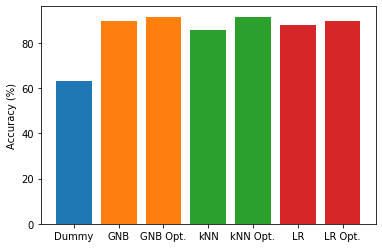

In [ ]:
dummy_names, gnb_names = ['Dummy'], ['GNB', 'GNB Opt.']
knn_names, lr_names = ['kNN', 'kNN Opt.'], ['LR', 'LR Opt.']
dummy_acc, gnb_acc = [63.208], [89.623, 91.509] 
knn_acc, lr_acc = [85.849, 91.509], [87.736, 89.623]
fig, ax = plt.subplots()
ax.set_ylabel("Accuracy (%)")
ax.bar(dummy_names, dummy_acc)
ax.bar(gnb_names, gnb_acc)
ax.bar(knn_names, knn_acc)
ax.bar(lr_names, lr_acc)
plt.show()

|                 | **Dummy**| **GNB** | **k-NN** | **LR** |
|:---------------:|:--------:|:-------:|:--------:|:------:|
| F1-Score (%)    | 77.457   | 95.714  | 93.706   | 91.667 |
| ΔF1 (%)         | + 0.0    | +3.515  | +3.773   | +0.633 |
| Train Time (ms) | 1.478    | 9.312   | 18.454   | 15.415 |
| Test Time (ms)  | 0.722    | 4.381   | 109.46   | 2.893  |

#### F1 Score

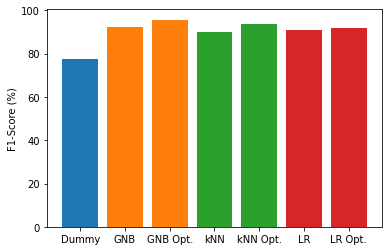

In [ ]:
dummy_names, gnb_names = ['Dummy'], ['GNB', 'GNB Opt.']
knn_names, lr_names = ['kNN', 'kNN Opt.'], ['LR', 'LR Opt.']
dummy_f1, gnb_f1 = [77.457], [92.199, 95.714] 
knn_f1, lr_f1 = [89.933, 93.706], [91.034, 91.667]
fig, ax = plt.subplots()
ax.set_ylabel("F1-Score (%)")
ax.bar(dummy_names, dummy_f1)
ax.bar(gnb_names, gnb_f1)
ax.bar(knn_names, knn_f1)
ax.bar(lr_names, lr_f1)
plt.show()

*Σημείωση:* Σαφώς οι χρόνοι που παραθέτουμε παραπάνω, μεταβάλλονται από εκτέλεση σε εκτέλεση, ενώ ενδεχομένως να μην είναι και τελείως ακριβείς (πχ. χρήση της `time()`), τους χρησιμοποιούμε για άτυπη ποιοτική αξιολόγηση.

#### Συμπεράσματα

Όσον αφορά στους χρόνους παρατηρούμε πως ο kNN όπως είναι αναμενόμενο, έχει πολύ μεγάλους χρόνους ταξινόμησης και εκπαίδευσης. (Χρειάζεται για κάθε πρόβλεψη να υπολογισθεί η απόσταση που έχουμε επιλέξει, από κάθε σημείο του test dataset. Ωστόσο και στην εκπαίδευση χρειάζεται να γίνει classification στο validation set.) Παρατηρούμε επίσης πως ο GNB εκπαιδεύεται πιο γρήγορα από όλους, ενώ στο classification υπερτερεί κάπως ο LR έναντι του GNB όσον αφορά στη "ταχύτητα".

Προφανώς αν αγνοησουμε τους χρόνους εκπαίδευσης και απόκρισης όπου ο dummy classifier έχει το μεγαλύτερο πλεονέκτημα, βλέπουμε πως τόσο στην ootb, όσο και στις optimized εκδοχές, η απόδοση των ταξινομητών είναι σημαντικά υψηλότερη από την αντίστοιχη του dummy.

Και στις δύο μετρικές, υπερτερεί ο GNB, ο οποίος ήδη υπερτερούσε στις out of the box συγκρίσεις. Ο kNN φαίνεται να επωφελήθηκε αρκετά από τα optimizations που κάναμε, ενώ από την άλλη ο LR δεν αύξησε ιδιαίτερα την απόδοση του, ειδικά στο f1 score.

Τόσο από άποψη χρόνου όσο και επίδοσης, φαίνεται πως **αξίζει να επιλέξουμε τον GNB** και για τις δύο μετρικές που μας ενδιαφέρουν. 

Η μοντελοποίηση της συμπεριφοράς των ηλεκτρονιών με γκαουσιανές κατανομές δεν είναι κάτι πρωτόγνωρο στη θεωρία του ηλεκτρομαγνητισμού. (βλ. θερμικός θόρυβος) Μπορεί ενδεχομένως και στο πείραμα που εξετάζουμε, μιας και έχουμε να κάνουμε με ακτινοβολία ηλεκτρονίων, να περιγράφεται κάπως η συμπεριφορά των δεδομένων μας από κατάλληλες Γκαουσιανές κατανομές. Με βάση αυτές τις σκέψεις, δεν μας παραξενεύει πως ο GNB φαίνεται να αποδίδει πολύ καλά στο πρόβλημα ταξινόμησης που ασχοληθήκαμε.

Παρακάτω παραθέτουμε το confusion matrix για τον πιο "ορθό" ταξινομητή (GNB) και για τον λιγότερο ορθό (LR).

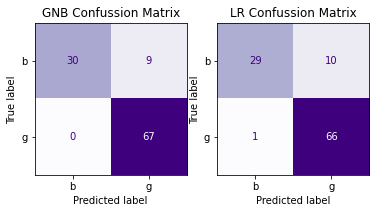

In [ ]:
fig, ax = plt.subplots(ncols = 2)
ConfusionMatrixDisplay.from_predictions(y_test, gnb_preds, ax = ax[0], cmap = 'Purples', colorbar = False)
ax[0].set_title("GNB Confussion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, lr_preds, ax = ax[1], cmap = 'Purples', colorbar = False)
ax[1].set_title("LR Confussion Matrix")
plt.show()

Όπως φαινόταν και από τις τιμές των μετρικών, βλέπουμε πως οι δύο ταξινομητές δεν διαφέρουν πολύ. Ο LR έχει ένα False Negative σε αντίθεση με τον GNB που δεν έχει κανενα. Επίσης έχει ένα περισσότερο False Positive. (Θεωρώντας πάντα το `g` ως positive)